# Supervised Learning and Emission Line Nebulae
This notebook explores the use of an ANN to do rapid BPT classifications.

The basic outline is as follows:
   1.  Obtain emission line ratios from 3Mdb with associated emission type 
   (i.e. Planetary Nebula, Supernova Remnant, etc.)
   2. Apply ANN to line ratios to find categorizing
   3. Verify results using emission type information
   

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
#import plotly.express as px
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from tensorflow.keras.regularizers import l2
from sklearn.ensemble import GradientBoostingClassifier
import pickle

In [2]:
# Read in line fluxes
# HII Regions
Param_dict_HII = {}
for line in open('Ratios_HII_ratios.txt').readlines():
    vals = [text.strip('\n') for text in line.split(' ')]
    Param_dict_HII[vals[0]] = [float(vals[1]), float(vals[2]), float(vals[3]), float(vals[4]), float(vals[5])]
# PNe
Param_dict_PNe = {}
for line in open('Ratios_PNe_ratios.txt').readlines():
    vals = [text.strip('\n') for text in line.split(' ')]
    Param_dict_PNe[vals[0]] = [float(vals[1]), float(vals[2]), float(vals[3]), float(vals[4]), float(vals[5])]
# SNR
Param_dict_SNR = {}
for line in open('Ratios_SNR_ratios.txt').readlines():
    vals = [text.strip('\n') for text in line.split(' ')]
    Param_dict_SNR[vals[0]] = [float(vals[1]), float(vals[2]), float(vals[3]), float(vals[4]), float(vals[5])]

print("We have %i HII regions"%len(Param_dict_HII))
print("We have %i Planetary Nebulae"%len(Param_dict_PNe))
print("We have %i Supernova Remnants"%len(Param_dict_SNR))

We have 35100 HII regions
We have 44245 Planetary Nebulae
We have 58903 Supernova Remnants


In [3]:
# Make Pandas DF and calculate ratios
HII = pd.DataFrame.from_dict(Param_dict_HII, orient="index", columns=['O3_hb', 's1s2_ha', 'n2_ha', 'O2_O3', 'ha'])#.sample(n=10000, replace=True).reset_index(drop=True)
HII['Type'] = HII.apply(lambda row: 0, axis=1)

PNe = pd.DataFrame.from_dict(Param_dict_PNe, orient="index", columns=['O3_hb', 's1s2_ha', 'n2_ha', 'O2_O3', 'ha']).sample(n=len(Param_dict_HII)).reset_index(drop=True)
PNe['Type'] = PNe.apply(lambda row: 1, axis=1)

SNR = pd.DataFrame.from_dict(Param_dict_SNR, orient="index", columns=['O3_hb', 's1s2_ha', 'n2_ha', 'O2_O3', 'ha']).sample(n=len(Param_dict_HII)).reset_index(drop=True)
SNR['Type'] = SNR.apply(lambda row: 2, axis=1)



total = HII.append(PNe).append(SNR)#.append(DIG)
total = total.sample(frac=1, random_state=1).reset_index(drop=True)  # Shuffle

In [4]:
total

,O3_hb,s1s2_ha,n2_ha,O2_O3,ha,Type
0,12.819000,0.275260,0.806140,0.109750,1.406800,1
1,8.925600,0.001943,0.000511,0.002905,0.025930,1
2,1.328100,0.035909,0.375770,0.179790,0.238790,0
3,0.006830,0.170160,0.190480,143.210000,0.978120,1
4,0.000016,0.168070,0.281950,8503.800000,0.135370,0
...,...,...,...,...,...,...
105295,0.307780,0.000083,0.000759,0.004560,0.001403,1
105296,0.884210,1.546400,2.125400,7.132200,6.306400,2
105297,0.749080,0.127590,0.025542,1.816400,1.360600,0
105298,40.144000,0.221160,0.773220,0.332730,13.357000,2


In [5]:
print(total['O3_hb'].min(), total['O3_hb'].max())
print(total['s1s2_ha'].min(), total['s1s2_ha'].max())
print(total['n2_ha'].min(), total['n2_ha'].max())
print(total['O2_O3'].min(), total['O2_O3'].max())
print(total['ha'].min(), total['ha'].max())

0.0 89.934
1.4253e-06 4.64
0.0 17.921
1.1273e-06 inf
0.0 51.325


# Machine Learning Algo
Now that we have the ratios for HII and PNe regions, we can apply our neural network

In [6]:
def create_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.Dense(256, input_shape=(3,),activation='relu'),
      tf.keras.layers.Dropout(0.20),  
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.20),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
    ])
model = create_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stopping_min_delta = 0.0001
early_stopping_patience = 4
reduce_lr_factor = 0.5
reuce_lr_epsilon = 0.009
reduce_lr_patience = 2
reduce_lr_min = 0.00008
early_stopping = EarlyStopping(monitor='val_loss', min_delta=early_stopping_min_delta, 
                                       patience=early_stopping_patience, verbose=2, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=reuce_lr_epsilon, 
                                  patience=reduce_lr_patience, min_lr=reduce_lr_min, mode='min', verbose=2)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'mse'])

2022-03-09 15:52:39.507801: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-09 15:52:39.509513: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
inputs = total[['O3_hb', 's1s2_ha', 'n2_ha']].to_numpy(dtype=float)
labels = total['Type'].to_list()
num_inputs = len(inputs)
div_per = 0.7
valid_per = 0.9
X_training = np.array(inputs[:int(div_per*num_inputs)], dtype=float)
Y_training = np.array(labels[:int(div_per*num_inputs)])
mm_scaler = PowerTransformer()#MinMaxScaler()
X_training = mm_scaler.fit_transform(X_training)

X_valid = np.array(inputs[int(div_per*num_inputs):int(valid_per*num_inputs)])
Y_valid = np.array(labels[int(div_per*num_inputs):int(valid_per*num_inputs)])
X_valid = mm_scaler.transform(X_valid)

X_test = np.array(inputs[int(valid_per*num_inputs):])
Y_test = labels[int(valid_per*num_inputs):]
X_test = mm_scaler.transform(X_test)

model.fit(x=X_training,
          y=Y_training,
          epochs=5,
          validation_data=(X_valid, Y_valid)
          )
model.save('ANN_model')

2022-03-09 15:52:39.857182: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
2304/2304 [==============================] - 16s 7ms/step - loss: 0.4741 - accuracy: 0.7791 - mse: 1.2350 - val_loss: 0.4083 - val_accuracy: 0.8120 - val_mse: 1.2455
Epoch 2/5
2304/2304 [==============================] - 16s 7ms/step - loss: 0.4087 - accuracy: 0.8151 - mse: 1.2493 - val_loss: 0.3769 - val_accuracy: 0.8401 - val_mse: 1.2441
Epoch 3/5
2304/2304 [==============================] - 15s 7ms/step - loss: 0.3917 - accuracy: 0.8246 - mse: 1.2528 - val_loss: 0.3712 - val_accuracy: 0.8320 - val_mse: 1.2510
Epoch 4/5
2304/2304 [==============================] - 16s 7ms/step - loss: 0.3828 - accuracy: 0.8273 - mse: 1.2548 - val_loss: 0.3685 - val_accuracy: 0.8370 - val_mse: 1.2364
Epoch 5/5
2304/2304 [==============================] - 15s 6ms/step - loss: 0.3736 - accuracy: 0.8324 - mse: 1.2563 - val_loss: 0.3596 - val_accuracy: 0.8501 - val_mse: 1.2479


2022-03-09 15:53:58.665087: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ANN_model/assets


In [8]:
pickle.dump(mm_scaler, open('BPT_scaler.pkl', 'wb'))

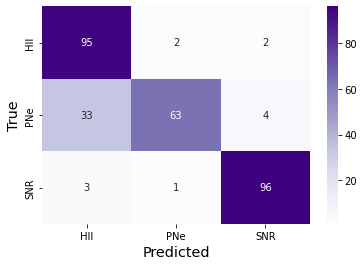

In [9]:
predictions = model.predict(X_test)
predictions = [np.argmax(pred) for pred in predictions]

matrix_conf = confusion_matrix(Y_test, predictions)

# Normalize confusion matrix
matrix_conf = matrix_conf.astype('float64') 
norm_fac = np.sum(matrix_conf[:], axis=1)
for row in range(matrix_conf.shape[0]):
    matrix_conf[row,:] = np.round(matrix_conf[row,:]*(1/norm_fac[row]),2)*100
# Plot confusion matrix    
sns_plot = sns.heatmap(matrix_conf, annot=True, cmap='Purples', xticklabels=['HII', 'PNe', 'SNR'], yticklabels=['HII', 'PNe', 'SNR'])
#sns_plot.set(xticklab
ls=np.arange(1,5)
#sns_plot.set(yticklabels=np.arange(1,5))
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
sns_fig = sns_plot.get_figure()
sns_fig.savefig('Confusion-Matrix-CNN.png')

## Gradient Boosted Decision Tree

In [10]:
# with sklearn
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.08,
    max_depth=5 , random_state=0).fit(X_training, Y_training)

predictions = clf.predict(X_test)

matrix_conf = confusion_matrix(Y_test, predictions)

# Normalize confusion matrix
matrix_conf = matrix_conf.astype('float64') 
norm_fac = np.sum(matrix_conf[:], axis=1)
for row in range(matrix_conf.shape[0]):
    matrix_conf[row,:] = np.round(matrix_conf[row,:]*(1/norm_fac[row]),2)*100
# Plot confusion matrix    
sns_plot = sns.heatmap(matrix_conf, annot=True, cmap='Purples', xticklabels=['HII', 'PNe', 'SNR'], yticklabels=['HII', 'PNe', 'SNR'])
#sns_plot.set(xticklabels=np.arange(1,5))
#sns_plot.set(yticklabels=np.arange(1,5))
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
sns_fig = sns_plot.get_figure()
sns_fig.savefig('Confusion-Matrix-GBDT.png', dpi=300)

KeyboardInterrupt: 

In [ ]:
importance = pd.DataFrame({'feature': ['O3_hb', 's1s2_ha', 'n2_ha'], 'importance': 100*np.round(clf.feature_importances_, 6)}).sort_values('importance', ascending=False)
importance

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.scatter(importance.feature, 'importance', data=importance)
fig.autofmt_xdate()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Feature Name', fontsize=25)
plt.ylabel('Importance of Feature (%)', fontsize=25)
plt.savefig('Feature-Importance.png')

In [ ]:
pickle.dump(clf, open('GBDT.pkl', 'wb'))

## Comparison with Kewley and Kaufmann lines for the 2D cuts

In [ ]:
fig = plt.figure(figsize=((10,8)))
HII_test = [reg for ct,reg in enumerate(inputs) if labels[ct] == 0]
PNe_test = [reg for ct,reg in enumerate(inputs) if labels[ct] == 1]
SNR_test = [reg for ct,reg in enumerate(inputs) if labels[ct] == 2]
plt.scatter(
    [np.log10(float(val[1])) for val in SNR_test], [np.log10(float(val[0])) for val in SNR_test],
    s=50, c='turquoise',
    alpha=0.15,
    marker='o',
    label='SNR'
)
plt.scatter(
    [np.log10(float(val[1])) for val in HII_test], [np.log10(float(val[0])) for val in HII_test],
    s=50, c='coral',
    marker='o',
    alpha=0.15,
    label='HII'
)
plt.scatter(
    [np.log10(float(val[1])) for val in PNe_test], [np.log10(float(val[0])) for val in PNe_test],
    s=50, c='gold',
    marker='o',
    alpha=0.15,
    label='PNe'
)

# Plot AGN Line
X_kew = np.linspace(-2,0.3)
Y_kew = (0.72/( X_kew  - 0.32  )) + 1.3
plt.plot(X_kew,   Y_kew, '-' , color='darkslategrey', lw=3, label='Main AGN') 

# Plot Liner/Sey2 Line
X_kauf = np.linspace(-0.3,1)
Y_kauf = (1.89*( X_kauf   )) + 0.76
plt.plot(X_kauf,   Y_kauf, '--' , color='darkslategrey', lw=3, label='LINER/Sey2')


plt.ylabel(r"O[III]/H$\beta$", fontsize=16, fontweight='bold')
plt.xlabel(r"S[II]/H$\alpha$", fontsize=16, fontweight='bold')
plt.xlim(-1.2, 0.8)
plt.ylim(-1,2)
leg = plt.legend(fontsize='x-large')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.savefig('SIIvsOIII.png')

In [ ]:
fig = plt.figure(figsize=((10,8)))

plt.scatter(
    [np.log10(float(val[2])) for val in SNR_test], [np.log10(float(val[0])) for val in SNR_test],
    s=50, c='turquoise',
    marker='o',
    alpha=0.15,
    label='SNR'
)
plt.scatter(
    [np.log10(float(val[2])) for val in HII_test], [np.log10(float(val[0])) for val in HII_test],
    s=50, c='coral',
    marker='o',
    alpha=0.15,
    label='HII'
)
plt.scatter(
    [np.log10(float(val[2])) for val in PNe_test], [np.log10(float(val[0])) for val in PNe_test],
    s=50, c='gold',
    marker='o',
    alpha=0.15,
    label='PNe'
)

# Plot Kewley 2001 Line
X_kew = np.linspace(-2,0.41)
Y_kew = (0.61/( X_kew  - 0.47  )) + 1.19
plt.plot(X_kew,   Y_kew, '-' , color='darkslategrey', lw=3, label='Kewley+01') 

# Plot Kaufman 2003 Line
X_kauf = np.linspace(-2,0)
Y_kauf = (0.61/( X_kauf  - 0.05  )) + 1.3
plt.plot(X_kauf,   Y_kauf, '--' , color='darkslategrey', lw=3, label='Kauffmann+03') 

plt.ylabel(r"O[III]/H$\beta$", fontsize=16, fontweight='bold')
plt.xlabel(r"N[II]/H$\alpha$", fontsize=16, fontweight='bold')
plt.xlim(-1.5, 1)
plt.ylim(-1, 2)
plt.legend(fontsize='x-large')
leg = plt.legend(fontsize='x-large')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.savefig("NIIvsOIII.png")

In [ ]:
total